# Data handling and cleaning

In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# global variables
DATA_PATH = r"../data/yellow_tripdata_2020-01.csv"
SHP_INPUT_PATH = r"../data/taxi_zones/taxi_zones.shp"
COLUMNS_TO_DROP = [
    'VendorID',
    'RatecodeID',
    'store_and_fwd_flag',
    'payment_type',
    'fare_amount',
    'extra',
    'mta_tax',
    'tip_amount',
    'tolls_amount',
    'improvement_surcharge', 
    'congestion_surcharge'
]

In [3]:
# important: all functions assume, in some manner, the dataset's data structure
# scripts do João Arthur
def read_data(path=None):
    """
    Reads the input CSV data to a dataframe.
    :path: (str) path to a custom data source.
    :return: (pandas.DataFrame) all input data.
    """
    return pd.read_csv(path or DATA_PATH)

def format_date_column(df, col, col_dow, col_hour, col_period):
    """
    Formats timestamp column to date and type columns.
    :param df: (pandas.DataFrame) dataset to have its timestamp column expanded to date and time columns.
    :param col: (str) column name containing timestamp data.
    :param col_dow: (str) column name for newly added day of the week column.
    :param col_hour: (str) column name for newly added hour column.
    :param col_period: (str) column name for newly added hour period of the day.
    :return: (pandas.DataFrame) dataset with date and time columns.
    """
    to_datetime_col = pd.to_datetime(df[col]).dt
    df[col_dow] = to_datetime_col.day_name()
    df[col_hour] = to_datetime_col.hour
    df[col_period] = pd.cut(
        to_datetime_col.hour,
        bins=[-.1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22],
        labels=["0-2", "2-4", "4-8", "8-10", "10-12", "12-14", "14-16", "16-18", "18-20", "20-22", "22-24"]
    )
    return df

def setup_data(df, columns_to_drop=None):
    """
    Reads the input CSV data to a dataframe.
    :param df: (pandas.DataFrame) dataset to be cleaned.
    :param columns_to_drop: (list-of-str) list of columns to be dropped.
    :return: (pandas.DataFrame) cleaned up dataset.
    """
    df = df.drop(columns_to_drop or COLUMNS_TO_DROP, axis=1)
    df = format_date_column(df, "tpep_pickup_datetime", "PU_Dow", "PU_Hour", "PU_Period")
#     df = format_date_column(df, "tpep_dropoff_datetime", "DO_Date", "DO_Time")
    # missing duration - still to do
    df["target"] = df["total_amount"] / df["trip_distance"]
    return df

def read_shape(path=None):
    """
    Reads the shapefile containing localtion polygons.
    :return: (geopandas.GeoDataFrame) data frame for the location shapefile data.
    """
    return gpd.read_file(path or SHP_INPUT_PATH)


In [24]:
df = read_data()
df1 = setup_data(df)
drop_cols = [
    'tpep_pickup_datetime',
    'tpep_dropoff_datetime',
    'passenger_count',
    'DOLocationID',
    'total_amount',
    'PU_Hour'
]
df1 = df1.drop(drop_cols, axis=1)
df1 = df1[df1["trip_distance"] > 0]

/Users/Joao/Desktop/FGV/Aplicações de Estatística Espacial/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


<AxesSubplot:xlabel='PU_Period', ylabel='target'>

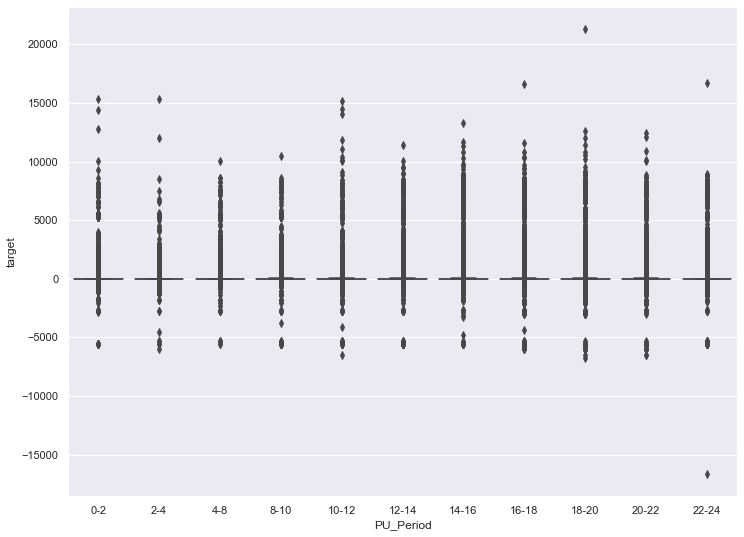

In [48]:
sns.boxplot(data=df1, x="PU_Period", y="target")

<AxesSubplot:>

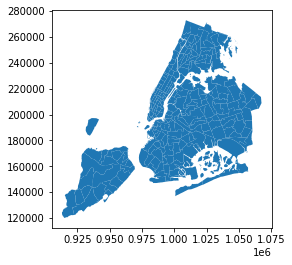

In [5]:
shp = read_shape()
shp = shp.drop(["Shape_Leng", "Shape_Area"], axis=1).set_index("OBJECTID")
shp.plot()

In [ ]:
outshp = shp.merge(df1, left_on="LocationID", right_on="PULocationID", how="left")

In [58]:
df2 = df1.groupby(["PULocationID", "PU_Dow", "PU_Period"]).target.mean().reset_index()

,PULocationID,PU_Dow,PU_Period,target
0,1,Friday,0-2,664.821429
1,1,Friday,2-4,79.203353
2,1,Friday,4-8,NaN
3,1,Friday,8-10,1790.500000
4,1,Friday,10-12,5165.208333
...,...,...,...,...
19938,265,Wednesday,14-16,116.667509
19939,265,Wednesday,16-18,563.042227
19940,265,Wednesday,18-20,18.032399
19941,265,Wednesday,20-22,126.311435


In [ ]:
df1.to_csv(r"../output/grouped_data.csv")